In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from tqdm import trange
from scipy import linalg as la

logabs = lambda x: torch.log(torch.abs(x))

device='cpu'
nr_samples=1000

In [2]:
class W_matrix(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        random_matrix = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(random_matrix)
        self.weight = nn.Parameter(q.float())

    def forward(self, input):
        out = input @ self.weight.transpose(0,1)

        logdet = torch.slogdet(self.weight.double())[1].unsqueeze(0).repeat(input.shape[0]).float()

        return out, logdet

    def reverse(self, output):
        return output @ self.weight.transpose(0,1).inverse()

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        self.w = torch.nn.ModuleList([W_matrix(2) for _ in range(len(mask))])

        self.bn = torch.nn.ModuleList([nn.BatchNorm1d(2, momentum=0.3) for _ in range(len(mask))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = (1 - self.mask[i]) * (x - t) * torch.exp(-s) + x_

            x = self.w[i].reverse(x)

            x = bn[i].running_mean + ((x - bn[i].bias) / bn[i].weight) * (bn[i].running_var + bn[i].eps).sqrt()
        return x

    def f(self, x, evaluate=False):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            if evaluate:
                variance = self.bn[i].running_var
                self.bn[i].eval()
            else:
                variance = z.var(dim=0, unbiased=False)

            z = self.bn[i](z)
            log_det_J += self.bn[i].weight.log().sum()
            log_det_J -= .5 * (variance + self.bn[i].eps).log().sum()

            self.bn[i].train()
          
            z, log_w = self.w[i](z)
            log_det_J += log_w

            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = z_ + (1 - self.mask[i]) * (z * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self, x, evaluate=False):
        z, det = self.f(x, evaluate)
        return self.prior.log_prob(z) + det

    def g_det(self, z):
        x = model.g(z)
        _, log_det_f = model.f(x, evaluate=True)
        det = torch.exp(-log_det_f)
      
        return x, det
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

In [4]:
#activation = nn.LeakyReLU
activation = nn.ReLU

nets = lambda: nn.Sequential(nn.Linear(2, 256), 
                             activation(), 
                             nn.Linear(256, 256),  
                             activation(),  
                             nn.Linear(256, 256),  
                             activation(),
                             nn.Linear(256, 2), 
                             nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(2, 256), 
                             activation(), 
                             nn.Linear(256, 256),  
                             activation(),
                             nn.Linear(256, 256),   
                             activation(), 
                             nn.Linear(256, 2))

Generate 8-modal dataset

In [5]:
def gaussians_on_circle(data_modes=8, sigma=0.05):
  centers = []

  for i in range(data_modes):
    angle = (1+2*i)*(np.pi / data_modes)
    centers.append(np.array([np.cos(angle), np.sin(angle)]))

  centers = np.array(centers)

  mix = distributions.Categorical(torch.ones(data_modes).to(device))
  comp = distributions.Independent(distributions.Normal(
              torch.from_numpy(centers).float().to(device), sigma*torch.ones(data_modes,2).to(device)), 1)
  
  return distributions.MixtureSameFamily(mix, comp)

Generate noisy circle

In [6]:
def noisy_circle(n, radius, noise):
  angle = 2*np.pi*np.random.sample(n)

  c = radius * np.stack((np.cos(angle), np.sin(angle)), axis=1)

  c += noise*np.random.normal(size=(n,2))

  return c

Visualize data

(-1.5, 1.5)

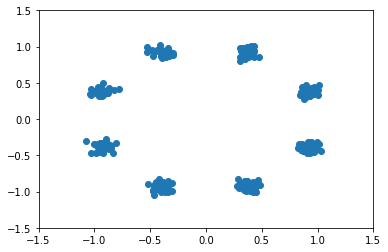

In [7]:
data = gaussians_on_circle().sample((300,))
plt.scatter(data[:,0], data[:,1])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

#data = datasets.make_moons(300, noise=.05)[0]
#plt.scatter(data[:,0], data[:,1])

#data = noisy_circle(100, 1, .05)
#plt.scatter(data[:,0], data[:,1])

In [8]:
masks = torch.from_numpy(np.array([[0, 1]] * 8).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), 0.5*torch.eye(2))
model = RealNVP(nets, nett, masks, prior)

In [9]:
data_generator = lambda n: gaussians_on_circle(8, .05).sample((n,))

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

x_grid_1 = np.linspace(-1.5, 1.5, 201)
x_grid_2 = np.linspace(1.5, -1.5, 201)
arr = np.transpose([np.tile(x_grid_1, len(x_grid_2)), np.repeat(x_grid_2, len(x_grid_1))])
arr = torch.from_numpy(arr).float()

x_val = data_generator(10000)

tr = trange(3001, desc='Bar desc', leave=True)
for t in tr:
    train_data = data_generator(nr_samples)
    loss = -model.log_prob(train_data).mean()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    tr.set_description(f'loss: {loss.detach().numpy():.2f}')
    
    if t % 25 == 0:
        val_loss = -model.log_prob(x_val).mean()
        lpmat = torch.exp(0.5*model.log_prob(arr, evaluate=True)).detach().numpy().reshape(len(x_grid_1), len(x_grid_2))
        plt.imshow(lpmat, cmap='viridis')
        plt.title(r'$p(x)$')
        
        plt.savefig(fname=f'eight_uni_{val_loss:.2f}_{t}.png', format='png')

        print(f'Validation loss: {val_loss}')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
masks = torch.from_numpy(np.array([[0, 1]] * 8).astype(np.float32))
prior = gaussians_on_circle(2, sigma=0.25)
model = RealNVP(nets, nett, masks, prior)

data_generator = lambda n: gaussians_on_circle(8, .05).sample((n,))

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

x_grid_1 = np.linspace(-1.5, 1.5, 201)
x_grid_2 = np.linspace(1.5, -1.5, 201)
arr = np.transpose([np.tile(x_grid_1, len(x_grid_2)), np.repeat(x_grid_2, len(x_grid_1))])
arr = torch.from_numpy(arr).float()

x_val = data_generator(10000)

tr = trange(3001, desc='Bar desc', leave=True)
for t in tr:
    train_data = data_generator(nr_samples)
    loss = -model.log_prob(train_data).mean()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    tr.set_description(f'loss: {loss.detach().numpy():.2f}')
    
    if t % 25 == 0:
        val_loss = -model.log_prob(x_val).mean()
        lpmat = torch.exp(0.5*model.log_prob(arr, evaluate=True)).detach().numpy().reshape(len(x_grid_1), len(x_grid_2))
        plt.imshow(lpmat, cmap='viridis')
        plt.title(r'$p(x)$')
        
        plt.savefig(fname=f'eight_bi_{val_loss:.2f}_{t}.png', format='png')

        print(f'Validation loss: {val_loss}')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
masks = torch.from_numpy(np.array([[0, 1]] * 8).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
model = RealNVP(nets, nett, masks, prior)

data_generator = lambda n: torch.from_numpy(datasets.make_moons(n, noise=.05)[0]).float()

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

x_grid_1 = np.linspace(-1.5, 2.5, 201)
x_grid_2 = np.linspace(1.2, -0.8, 201)
arr = np.transpose([np.tile(x_grid_1, len(x_grid_2)), np.repeat(x_grid_2, len(x_grid_1))])
arr = torch.from_numpy(arr).float()

x_val = data_generator(10000)

tr = trange(3001, desc='Bar desc', leave=True)
for t in tr:
    train_data = data_generator(nr_samples)
    loss = -model.log_prob(train_data).mean()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    tr.set_description(f'loss: {loss.detach().numpy():.2f}')
    
    if t % 25 == 0:
        val_loss = -model.log_prob(x_val).mean()
        lpmat = torch.exp(0.5*model.log_prob(arr, evaluate=True)).detach().numpy().reshape(len(x_grid_1), len(x_grid_2))
        plt.imshow(lpmat, cmap='viridis')
        plt.title(r'$p(x)$')
        
        plt.savefig(fname=f'moons_uni_{val_loss:.2f}_{t}.png', format='png')

        print(f'Validation loss: {val_loss}')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
masks = torch.from_numpy(np.array([[0, 1]] * 8).astype(np.float32))
prior = gaussians_on_circle(2, sigma=0.25)
model = RealNVP(nets, nett, masks, prior)

data_generator = lambda n: torch.from_numpy(datasets.make_moons(n, noise=.05)[0]).float()

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

x_grid_1 = np.linspace(-1.5, 2.5, 201)
x_grid_2 = np.linspace(1.2, -0.8, 201)
arr = np.transpose([np.tile(x_grid_1, len(x_grid_2)), np.repeat(x_grid_2, len(x_grid_1))])
arr = torch.from_numpy(arr).float()

x_val = data_generator(10000)

tr = trange(3001, desc='Bar desc', leave=True)
for t in tr:
    train_data = data_generator(nr_samples)
    loss = -model.log_prob(train_data).mean()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    tr.set_description(f'loss: {loss.detach().numpy():.2f}')
    
    if t % 25 == 0:
        val_loss = -model.log_prob(x_val).mean()
        lpmat = torch.exp(0.5*model.log_prob(arr, evaluate=True)).detach().numpy().reshape(len(x_grid_1), len(x_grid_2))
        plt.imshow(lpmat, cmap='viridis')
        plt.title(r'$p(x)$')
        
        plt.savefig(fname=f'moons_bi_{val_loss:.2f}_{t}.png', format='png')

        print(f'Validation loss: {val_loss}')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.